In [2]:
import numpy as np
import matplotlib.pyplot as plt
import skimage
from skimage import io
import seaborn as sns
import scipy
from scipy import stats
import sklearn
from sklearn.neighbors import KernelDensity
from skimage import feature
from skimage import measure
from skimage import exposure
from scipy import ndimage as ndi
from skimage.morphology import disk
from skimage.morphology import erosion, dilation, opening, closing, white_tophat
import pandas as pd
from sklearn.metrics.pairwise import euclidean_distances
from numpy.matlib import repmat
import pickle

In [3]:
path = '/Volumes/data_ssd2/Rojas_Lab/data'
expt_id = '/250606_bFB323_10uM_IPTG_tun'
conds=['10uM_IPTG','0min','10min','20min','30min','50min','70min','90min']
times=[-5,0,10,20,30,50,70,90]
scene_nums=[5,2,2,2,2,3,2,2]

i0=0
gam=1.0
thresh = 0.00012
slope_cutoff, R2_cutoff=0.8, 0.8
lin_reg_thresh = 0.9
# thresh=0.002 # for mNeonGreen
min_sig = 2
max_sig = 4
ovrlap = 0.6
cutoff_num=10
dt=0.04

In [4]:
class trace(object):  # we will define an object called a trace for each MreB filament.
    trackCount = 0  # total number of tracks

    def __init__(self, parameters):  # parameters = [coords(y,x), frame]
        self.coords = [parameters[0]]
        self.frames = [parameters[1]]
        self.displacement = []
        trace.trackCount += 1
        self.id = trace.trackCount

    def timepoint(self, parameters):  # parameters = [coords(y,x), frame]
        self.coords = self.coords + [parameters[0]]
        self.frames = self.frames + [parameters[1]]
        self.displacement = self.displacement + [parameters[2]]

def squared_displacements(traces):
    dt = 0.04  # frame rate
    lscale = 0.0929  # Microns per pixel.
    max_len=np.amax([len(obj.frames) for obj in traces])
    temp_dists_rec=np.nan*np.ones([len(traces),max_len])
    i0=0
    for obj in traces:
        temp_coords = np.copy(obj.coords)
        temp_frames = np.copy(obj.frames)
        # This generates the distances between our initial point and each subsequent point over time
        temp_dists = np.linalg.norm(
            temp_coords - repmat(np.reshape(temp_coords[0, :] + 0.001 * np.random.normal(size=2),
                                            [1, 2]), temp_coords.shape[0], 1), axis=1) # adding jitter because we take logs so we can't have log(0)
        xv = dt * (temp_frames - temp_frames[0] + 0.001)
        yv = temp_dists * lscale
        temp_dists_rec[i0,:len(yv)]=yv[:]
        i0+=1
    return temp_dists_rec*temp_dists_rec

First, let's import our data.

In [5]:
expt_ids=['/250606_bFB323_10uM_IPTG_tun', '/250609_bFB323_10uM_IPTG_tun_TIRF', '/250609_bFB323_10uM_IPTG_Tun_TIRF_v2']

path = '/Volumes/data_ssd2/Rojas_Lab/data'
conds=['10uM_IPTG','0min','10min','20min','30min','50min','70min','90min']
times=[-5,0,10,20,30,50,70,90]
scene_nums_ls=[[5,2,2,2,2,3,2,2],[3,2,2,2,2,2,2,2,2],[3,2,2,2,2,2,2,2,2]]

i0=0
gam=1.0
thresh = 0.00012
slope_cutoff, R2_cutoff=0.8, 0.8
lin_reg_thresh = 0.9
# thresh=0.002 # for mNeonGreen
min_sig = 2
max_sig = 4
ovrlap = 0.6
cutoff_num=10

dt=0.04

/var/folders/7d/cgvlmd010jb53nbnkbjsc8r80000gp/T/ipykernel_61703/3542033661.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


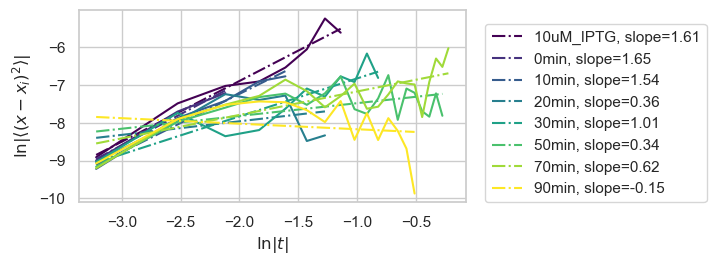

/var/folders/7d/cgvlmd010jb53nbnkbjsc8r80000gp/T/ipykernel_61703/3542033661.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


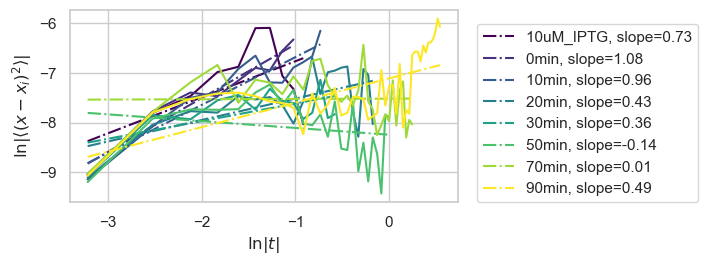

/var/folders/7d/cgvlmd010jb53nbnkbjsc8r80000gp/T/ipykernel_61703/3542033661.py:7: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis')


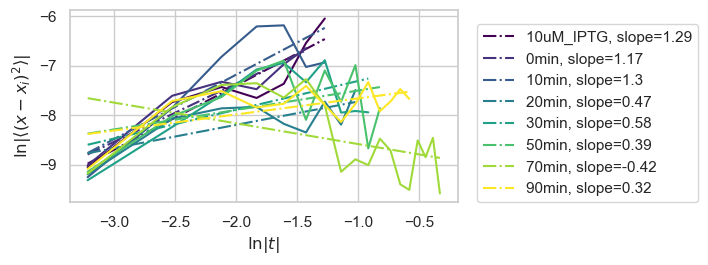

In [6]:
cols=[r'Diffusion exponent', 'Condition', 'Time (min)']
df=pd.DataFrame(columns=cols)
for temp_ind in range(len(expt_ids)):
    expt_id=expt_ids[temp_ind]
    scene_nums=scene_nums_ls[temp_ind]
#     slopes=np.nan*np.ones(len(conds))
    cmap = plt.cm.get_cmap('viridis')
    num_colors = len(conds)
    sample_points = np.linspace(0, 1, num_colors)
    sampled_colors = cmap(sample_points)

    fig=plt.figure(figsize=[5.0,2.5])
    sns.set(font_scale=1.0)
    sns.set_style('whitegrid')
    plt
    ax=plt.subplot(1,1,1)
    for cond in conds:
        temp_data=[]
        for scene_num in np.arange(1,scene_nums[conds.index(cond)]+1):
            temp_path=path+expt_id+'/'+cond+expt_id+'_'+cond+'_s{0}_tracked_filt.pkl'.format(str(scene_num).zfill(3))
            with open(temp_path, "rb") as input:
                temp_data += pickle.load(input)
        temp_dists_rec=squared_displacements(temp_data)
        cap_ind=np.argmax(np.nonzero(np.sum(~np.isnan(temp_dists_rec),axis=0)>cutoff_num))
        temp_dists_rec1=temp_dists_rec[:,1:cap_ind]
    #     print(cond,len(temp_data))

        xv=np.log(dt*(np.arange(1,temp_dists_rec1.shape[1]+1)))
        yv=np.log(np.nanmean(temp_dists_rec1*temp_dists_rec1,axis=0))
        vals=scipy.stats.linregress(xv,yv)
#         slopes[conds.index(cond)]=vals[0]
        temp_df=pd.DataFrame(columns=cols,data=[[vals[0],expt_id,times[conds.index(cond)]]])
        df=pd.concat([df,temp_df])
#         plt.plot(xv,yv,label=cond+r', $\ln(\langle x^2\rangle)$',linestyle='-',color=sampled_colors[conds.index(cond)])
        plt.plot(xv,yv,linestyle='-',color=sampled_colors[conds.index(cond)])
        temp_xv=np.linspace(xv[0],xv[-1],50)
    #     plt.hold('on')
        plt.plot(temp_xv,vals[0]*temp_xv+vals[1],linestyle='-.',label=cond+', slope={0}'.format(np.around(vals[0],2)),color=sampled_colors[conds.index(cond)])
        # plt.fill_between(dt*np.arange(temp_dists_rec.shape[1]),np.nanmean(temp_dists_rec*temp_dists_rec,axis=0)-np.nanstd(temp_dists_rec*temp_dists_rec,axis=0)/np.sqrt(np.sum(~np.isnan(temp_dists_rec),axis=0)),np.nanmean(temp_dists_rec*temp_dists_rec,axis=0)+np.nanstd(temp_dists_rec*temp_dists_rec,axis=0)/np.sqrt(np.sum(~np.isnan(temp_dists_rec),axis=0)),color='k',alpha=0.2)
    plt.legend(loc=[1.05,0.0])
    plt.xlabel(r'$\ln|t|$')
    plt.ylabel(r'$\ln|\langle (x-x_i)^2\rangle|$')
    fig.savefig('./outputs/compiled_data/SMT'+expt_id+'_diffusion_plots.pdf',bbox_inches='tight')
    plt.show()

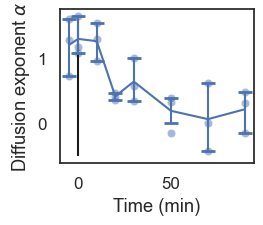

In [11]:
fig=plt.figure(figsize=[2.5,2.0])
ax=plt.gca()
sns.set(font_scale=1.1)
sns.set_style('white')
ax.vlines(0.0,ymin=-0.5,ymax=1.6,color='k',linestyle='-')
sns.lineplot(data=df,x='Time (min)',y='Diffusion exponent',err_style='bars',err_kws={'capsize':5.0,'capthick':2.0})
sns.scatterplot(data=df,x='Time (min)',y='Diffusion exponent',alpha=0.5)
plt.ylabel(r'Diffusion exponent $\alpha$')
# plt.legend(loc=[0.3,0.8])
fig.savefig('./outputs/compiled_data/SMT/combined_data.pdf',bbox_inches='tight')
fig.savefig('./outputs/compiled_data/SMT/combined_data.png',bbox_inches='tight',dpi=300)